# Random forest lepton flavor study
(Oct 26, 2016)

This study was done using the the same, very simliar, set-up and methodology to what was done with TMVA over during 2015-mid2016. There are a few glaring mistakes and over sights which will be noted but not corrected in this study. The issues are outlined below. 

### Issues 

There are a few issues to note. First that the original forest was not trained on 1/3 of the mc, but ~ 1/3 of WW and the rest of the same order as the WW.  ( 50,000-WW, 70,000-DY, 33,000-TT ) More importantly when producing yeild tables the entire Monte Carlo dataset set was used, including the portion of the set which had been used for training. What worse is that only ~2/3 of the WW set was avalible. So over 50% of the data set used to test on was also used to train. :( 

Other things: 

- At this point in time bagged fraction isn't known to be a tunable parameter.

- Sklearn seems to cut a bit more harshly on TT then DY as the yields for TT are abit lower while DY is markedly higher then what's produced by TMVA.

- 100 trees were trained for each flavor and for the combined set here.  The TMVA forest held 300 trees.

### Future 

I plan to move away from TMVA.  Before doing so I need to determine why their is such a large difference in the DY yields. I plan on completing the analysis with 1/3 of the MC where the number of DY and TT are weighted such that the weighted sum of each process are the same magnitude.

link to that note book: 

=========================


## Set up:

In [409]:
run ../prep_ana.py

Loading plotting specs...
8 or 13 TeV:
Loading 8TeV
unc_mc_process and scales as dictionaries
Load MC and Data?False
df = pd.concat([df_dy0, df_dy1, df_dy2, df_dy3, df_dy4, df_dy_m_10, df_ww, df_tt_l, df_tt_sl, df_zz_ln, df_wz_ln, df_wz_lq ])


In [3]:
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

In [4]:
%matplotlib inline

In [5]:
def process_yields( df ):
    for process in df.process.unique():
        for decay in df[df.process == process].process_decay.unique():
            if decay in scales.keys():
                print process, decay, df[(df.process_decay==decay)].shape[0], df[(df.process_decay==decay)].shape[0] * scales[decay]

In [6]:
# Concate processes and preform preselection
df_train_test = pre_cuts(df)
df_train_test = df_train_test.reset_index()

In [7]:
process_yields( df_train_test )

DY DYJetsToLL_M-50 284120 661993.59859
DY DYJetsToLL_M-10to50 29237 236433.007796
WW WW 114873 12943.7912546
Top ttbar_leptonic 646461 24628.8666601
Top ttbar_semileptonic 4888 415.452314632
Top Tbar_s-channel 7 2.42704
Top Tbar_t-channel 102 31.8792168974
Top Tbar_tW-channel 4318 1926.7357723
Top T_s-channel 15 3.6135978089
Top T_t-channel 231 68.2927029155
Top T_tW-channel 4420 1955.61228394
ZZ ZZJetsTo2L2Q 24683 620.144241806
ZZ ZZJetsTo2L2Nu 14842 217.397279956
WZ WZJetsTo3LNu 147190 1537.48775879
WZ WZJetsTo2L2Q 44892 615.982691488


In [8]:
#Select a subset of events that will be used for training and testing

#train_DY = df_train_test[df_train_test.process=="DY"].sample( frac=0.4 )
train_WW = df_train_test[df_train_test.process=="WW"].sample( frac=0.4)#n=train_DY.shape[0]*2 )
train_DY = df_train_test[df_train_test.process=="DY"].sample( n=train_WW.shape[0]*2  )#.45
train_TT = df_train_test[df_train_test.process=="Top"].sample( n=train_WW.shape[0]*2 )

train = pd.concat( [train_WW, train_TT, train_DY] )

train_same = train[ train.lep_Type < 0]
train_diff = train[ train.lep_Type > 0]

In [10]:
#Set up test sets

test_same = df_train_test[ df_train_test.lep_Type < 0].drop( train_same.index )
test_diff = df_train_test[ df_train_test.lep_Type > 0].drop( train_diff.index )

scales_test = {key: scales[key] * ( float(df_train_test[ df_train_test.process_decay == key].shape[0])/ float(test_same[ test_same.process_decay == key].shape[0] + test_diff[ test_diff.process_decay == key].shape[0]) ) for key in scales.keys() if key in df_train_test.process_decay.unique() } 

In [11]:
df_da_a = rp.read_root(data_path+"/muon_2012A_complete.root")
df_da_b = rp.read_root(data_path+"/muon_2012B_complete.root")
df_da_c = rp.read_root(data_path+"/muon_2012C_complete.root")
df_da_d = rp.read_root(data_path+"/muon_2012D_complete.root")

df_da = pd.concat([df_da_a, df_da_b, df_da_c, df_da_d])

In [12]:
df_da_pre = pre_cuts(df_da)
df_da_same = df_da_pre[ df_da_pre.lep_Type < 0]
df_da_diff = df_da_pre[ df_da_pre.lep_Type > 0]

# Features

In [94]:
features = ['qT',\
            'dPhiLL', 'HT', 'recoil']

# Classification training and testing

In [95]:
#Create labels 
#labels same
labels_same = np.empty( train_same.shape[0] )
weights_same = np.empty( train_same.shape[0])

labels_same[(train_same.process == "WW").as_matrix()] = 1
labels_same[(train_same.process == "Top").as_matrix()] = 2
labels_same[(train_same.process == "DY").as_matrix()] = 2

weights_same[(train_same.process == "WW").as_matrix()] = 1
weights_same[(train_same.process == "Top").as_matrix()] = 1
weights_same[(train_same.process == "DY").as_matrix()] = 1


#labels diff
labels_diff = np.empty( train_diff.shape[0] )
weights_diff = np.empty( train_diff.shape[0])

labels_diff[(train_diff.process == "WW").as_matrix()] = 1
labels_diff[(train_diff.process == "DY").as_matrix()] = 2
labels_diff[(train_diff.process == "Top").as_matrix()] = 2

weights_diff[(train_diff.process == "WW").as_matrix()] = 1
weights_diff[(train_diff.process == "DY").as_matrix()] = 1
weights_same[(train_same.process == "Top").as_matrix()] = 1


## Different flavor 

In [96]:
clf_d = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
clf_s = RandomForestClassifier(n_estimators=50, n_jobs=-1, min_samples_split=10, max_depth=15, max_features='sqrt')
#n_estimators=150

In [97]:
clf_d = clf_d.fit( np.float32(train_diff[features].values) , np.float32(labels_diff), sample_weight=weights_diff)

In [98]:
print clf_d.score(np.float32(train_diff[features].values), np.float32(labels_diff), weights_diff)

0.947037929722


In [99]:
pred_d = clf_d.predict_proba(np.float32(test_diff[features].values))
test_diff["pred"] = pred_d[:,0]

In [100]:
pred_d = clf_d.predict_proba(np.float32(df_da_diff[features].values))
df_da_diff["pred"] = pred_d[:,0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(<matplotlib.figure.Figure at 0x3c4ca9410>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x3d2fc67d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x3cb3610d0>], dtype=object))

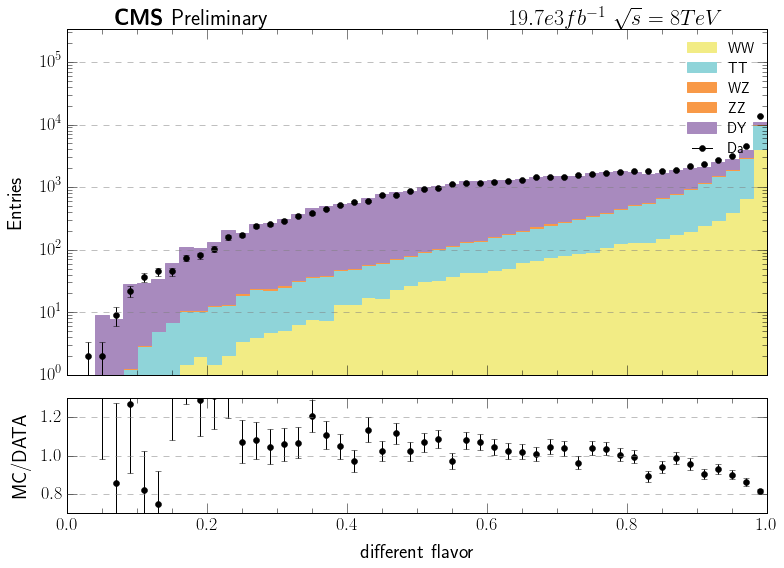

In [198]:
bins_mc = bin_df( test_diff[ test_diff.mll > 30], "pred", range=(0,1), bins=50, scales=scales_test)
bins_da = bin_df( df_da_diff[ df_da_diff.mll > 30], "pred", range=(0,1), bins=50)

full_plot( bins_mc, bins_da, color="color_1", title="different flavor")

## Same Flavor

In [102]:
clf_s = clf_s.fit( np.float32(train_same[features].values) , np.float32(labels_same), sample_weight=weights_same)

In [103]:
print clf_s.score(np.float32(train_same[features].values), np.float32(labels_same), weights_same)

0.920127096205


In [104]:
pred_s = clf_s.predict_proba(np.float32(test_same[features].values))
test_same["pred"] = pred_s[:,0]

In [105]:
pred_s = clf_s.predict_proba(np.float32(df_da_same[features].values))
df_da_same["pred"] = pred_s[:,0]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(<matplotlib.figure.Figure at 0x3d3ff1590>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x3cb995c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x3dc046fd0>], dtype=object))

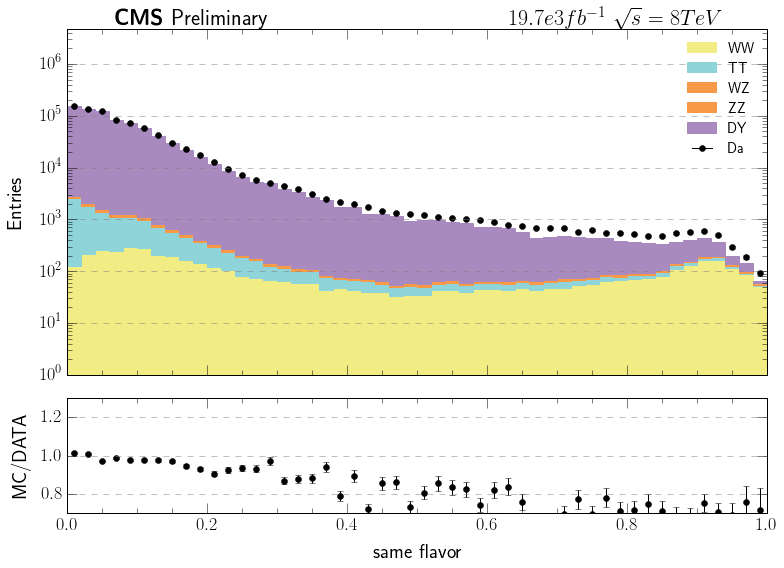

In [199]:
bins_mc = bin_df( test_same[ test_same.mll > 30], "pred", range=(0,1), bins=50, scales=scales_test)
bins_da = bin_df( df_da_same[ df_da_same.mll > 30], "pred", range=(0,1), bins=50)

full_plot( bins_mc, bins_da, color="color_1", title="same flavor")

(<matplotlib.figure.Figure at 0x43fc27f50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x4236cb890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x446737c90>], dtype=object))

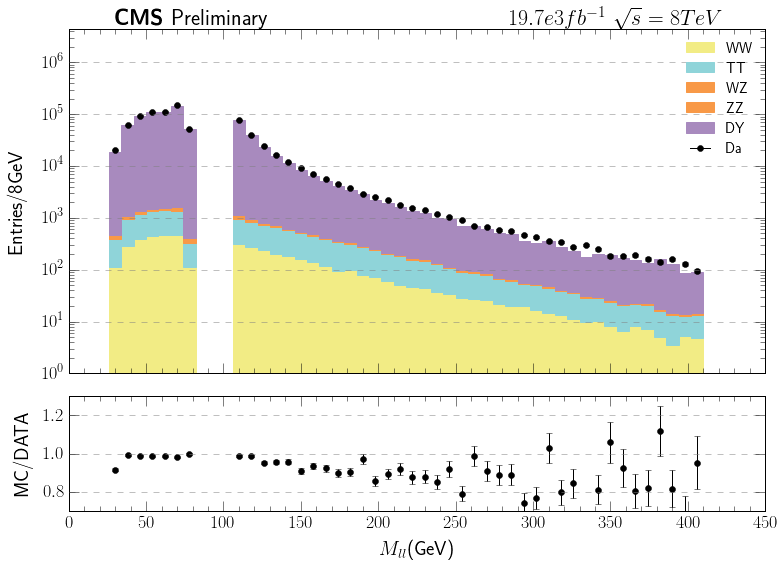

In [112]:
bins_mc = bin_df( test_same[ test_same.mll > 30], "mll", scales=scales_test)
bins_da = bin_df( df_da_same[ df_da_same.mll > 30], "mll", )

full_plot( bins_mc, bins_da, color="color_1",)

(<matplotlib.figure.Figure at 0x35ededf50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2e6653e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x35f144690>], dtype=object))

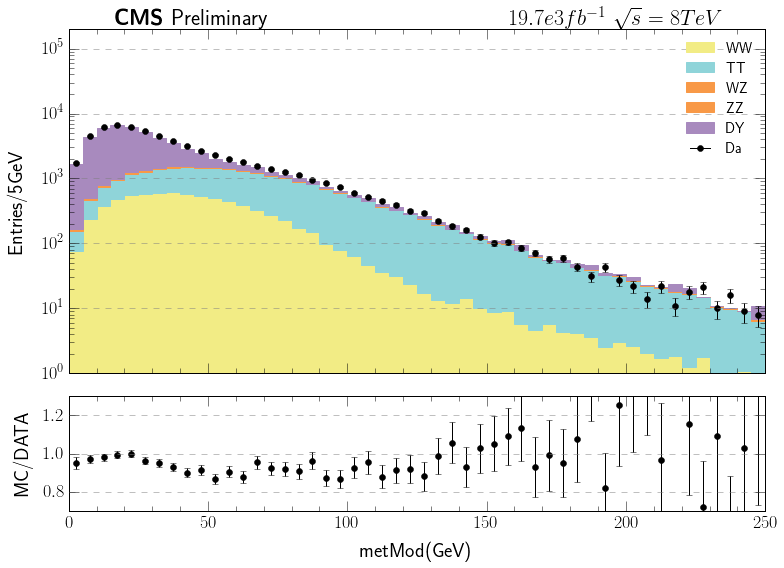

In [76]:
bins_mc = bin_df( test_diff[ test_diff.mll > 30], "metMod", scales=scales_test)
bins_da = bin_df( df_da_diff[ df_da_diff.mll > 30], "metMod",)

full_plot( bins_mc, bins_da, color="color_1",)

## same + different flavors

In [15]:
clf = clf.fit( np.float32(train[features].values) , np.float32(labels), sample_weight=weights)

In [32]:
print clf.score(np.float32(train[features].values), np.float32(labels), weights)

0.961823529412


In [16]:
pred = clf.predict_proba(np.float32(df[features].values))

In [34]:
df["pred"] = pred[:,0]

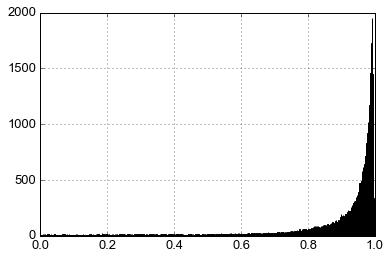

In [55]:
df[ df.WW == 1 ].pred.hist(bins=1000)

In [36]:

scales = {"WW": 19.7e3 * 59.8 /  10000431.0 ,\
          "DY": 19.7e3 * 3531.9 / 30459500. ,\
          "TT": 19.7e3 * 25.81 / 12011428.,\
          "ZZ": 19.7e3 * 9.03 / 9799908.,\
          "WZ": 19.7e3 * 1.07 / 2017979., "WJ": 1 }


for process in scales.keys():
    if process in df.keys():
        print process, df[ (df[process] == 1) & (df.pred > .96912) & (df.lep_Type > 0)].shape[0] *  scales[process],\
        df[ (df[process] == 1) & (df.pred > .96912) & (df.lep_Type < 0)].shape[0] *  scales[process]

TT 305.853610245 103.674244062
WW 3821.73461124 1266.56442707
ZZ 37.6287318207 40.7927629525
DY 1365.45077956 778.32943942
WZ 261.823028882 105.08718277


In [51]:
df.shape

(4848788, 40)

# Results as of sept 21 

### trained seperately:

Process:    | WW | DY | TT | ZZ+WZ
---         |---| ---|--- |---
same flavor |1684|395|71 | 192 
diff flavor |3799|661|139 | 220 

Significant differences

- diff DY 661 vs 106 
- diff TT 139 vs 433


### trained together:

Process:    | WW | DY | TT | ZZ+WZ
---         |---| ---|--- |---
same flavor |1057|182|36 | 101 
diff flavor |4426|485|178 | 279 

# End

# WW practice selection


In [344]:
    a = 1. * df_train_test.METProj_sin.values
    a[df_train_test.process.values == "DY"] = df_train_test.METProj_sin.values[df_train_test.process.values == "DY"] * 1.059
    df_train_test["METProj_sin"] = a

In [286]:
def process_yields_v2( df ):
    tot = 0
    for process in df.process.unique():
        sum_process = 0
        for decay in df[df.process == process].process_decay.unique():
            if decay in scales.keys():
                #print process, decay, df[(df.process_decay==decay)].shape[0], df[(df.process_decay==decay)].shape[0] * scales[decay]
                sum_process += df[(df.process_decay==decay)].shape[0] * scales[decay]
        print process, sum_process
        tot += sum_process
    print "tot",tot

In [345]:
def WW_same( df ):
  initial_cuts = (df.mll > 30 )  & (df.numbExtraLep == 0) & (df.numb_jets <  3) & ( df.metMod > 50 ) & (df.mllMET > 100) & (df.HT < 50) & (df.qT > 35)

  basic_df_0j_cuts = initial_cuts & (df.lep_Type < 0) & (df.METProj_sin > 50)
  return df[basic_df_0j_cuts]

In [346]:
process_yields_v2( WW_same(df_train_test) )

DY 509.999167455
WW 1055.69089572
Top 716.377741996
ZZ 53.8359457989
WZ 90.025057429
tot 2425.9288084


(<matplotlib.figure.Figure at 0x432330d90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x3b6858bd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x3ebe91c10>], dtype=object))

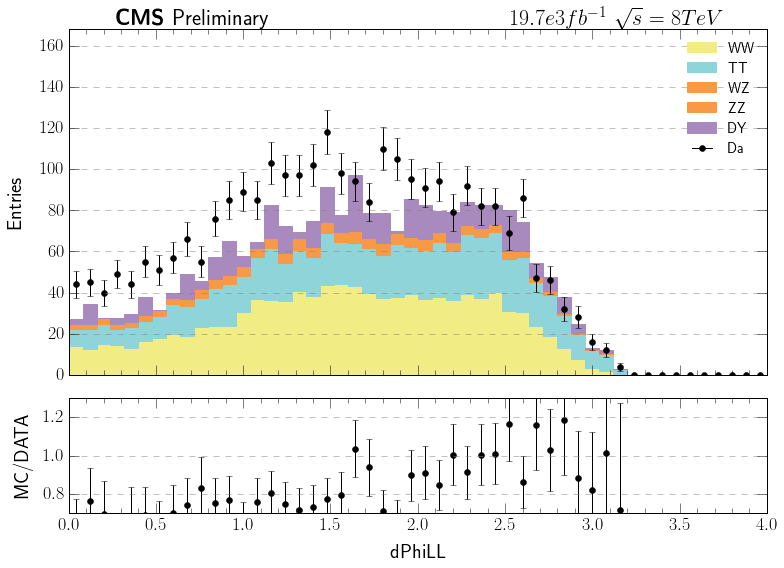

In [367]:
bins_mc = bin_df( WW_same(df_train_test), "dPhiLL",)
bins_da = bin_df( WW_same(df_da_pre), "dPhiLL",)

full_plot( bins_mc, bins_da, color="color_1", logy=False, y_range=(0,np.max(bins_da["Da"][0])+50))

In [376]:
def WW_diff( df ):
  initial_cuts = (df.mll > 30 )  & (df.numbExtraLep == 0) & (df.numb_jets <  3) & ( df.metMod > 50 ) & (df.mllMET > 100) & (df.HT < 50) & ( df.metMod < 120 )

  basic_df_0j_cuts = initial_cuts & (df.lep_Type > 0) & (df.METProj_sin > 30)
  return df[basic_df_0j_cuts]

In [377]:
process_yields_v2( WW_diff(df_train_test) )

DY 232.99788772
WW 2028.44994181
Top 1416.39343217
ZZ 2.8542157949
WZ 120.533809809
tot 3801.2292873


(<matplotlib.figure.Figure at 0x4439b7fd0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x3cade0f50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x4317a2810>], dtype=object))

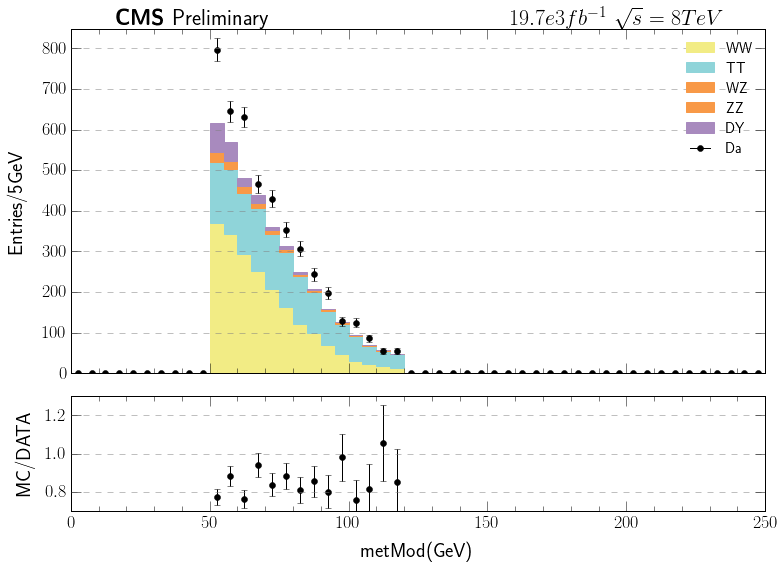

In [363]:
bins_mc = bin_df( WW_diff(df_train_test), "metMod",)
bins_da = bin_df( WW_diff(df_da_pre), "metMod",)

full_plot( bins_mc, bins_da, color="color_1", logy=False, y_range=(0,np.max(bins_da["Da"][0])+50))

In [378]:
def calc_cross( df_mc, df_da ):
    sum_events = 0
    for key in scales:
        if key in df_mc.process_decay.unique() and key != 'WW':
            sum_events += df_mc[df_mc.process_decay == key].shape[0] * scales[key]
    LBrEff = 19.7e3 * (3*.108)**2 *.122
    print df_mc[df_mc.process == 'WW'].shape[0] * scales["WW"] / (LBrEff * df_mc[df_mc.process == 'WW'].shape[0] / (df[df.process =='WW'].shape[0]) )
    return (df_da.shape[0] - sum_events -217- 447 ) / (LBrEff * df_mc[df_mc.process == 'WW'].shape[0] / (df[df.process =='WW'].shape[0]) )

In [379]:
calc_cross( pd.concat( [WW_diff(df_train_test), WW_same(df_train_test)]), pd.concat([WW_diff(df_da_pre), WW_same(df_da_pre)]) ) 

57.3231569627


65.36814119893668

In [375]:
calc_cross( WW_diff(df_train_test), WW_diff(df_da_pre) ) 

57.3231569627


65.00328497623353

In [373]:
calc_cross(WW_same(df_train_test), WW_same(df_da_pre))

57.3231569627


66.06919165481271

In [335]:
189+81+114+63

447

In [197]:
(831.59 + 2684.7 - 823 - 2213 ) / ( 1031.59 + 2884.7)

0.12263902826399474

In [163]:
df_train_test.process_decay.unique()

array(['DYJetsToLL_M-50', 'DYJetsToLL_M-10to50',
       'DYJetsToLL_M-10to50filter', 'WW', 'ttbar_leptonic',
       'ttbar_semileptonic', 'Tbar_s-channel', 'Tbar_t-channel',
       'Tbar_tW-channel', 'T_s-channel', 'T_t-channel', 'T_tW-channel',
       'ZZJetsTo2L2Q', 'ZZJetsTo2L2Nu', 'WZJetsTo3LNu', 'WZJetsTo2L2Q'], dtype=object)

In [196]:
( 831.59 + 2684.7)/ (19.7e3 * (3*.108)**2 *.122 * 3000 / (df[df.process =='WW'].shape[0]*scales['WW']) )

67.18828119878027

#b# 

In [275]:
df.keys()

Index([u'index', u'lep1_pt', u'lep2_pt', u'lep3_pt', u'numb_jets', u'dPhiLL',
       u'qT', u'HT', u'lep1_Charge', u'lep2_Charge', u'lep_Type', u'lep1_type',
       u'lep2_type', u'lep1_eta', u'lep2_eta', u'lep1_phi', u'lep2_phi',
       u'lep1_iso', u'lep2_iso', u'soft_muon_pt', u'soft_muon_phi',
       u'soft_muon_eta', u'lep1_mother', u'lep2_mother', u'met_corrected',
       u'met_trk', u'metMod', u'jet1_pt', u'jet2_pt', u'jet3_pt', u'jet4_pt',
       u'jet5_pt', u'jet6_pt', u'jet1_csv', u'jet2_csv', u'jet3_csv',
       u'jet1_phi', u'jet2_phi', u'jet1_eta', u'jet2_eta', u'numbExtraLep',
       u'mll', u'mllMET', u'recoil', u'dPhiLLJet', u'numb_BJet',
       u'numb_BJet_gen', u'dPhiLLMET', u'dPhiMETJet', u'METProj',
       u'METProj_sin', u'METProj_trk_sin', u'met_phi', u'met_corrected_phi',
       u'met_trk_phi', u'met_over_sET', u'nPartons', u'npv', u'tot_npv',
       u'gen_npv', u'runNum', u'lumiSec', u'eventNumb', u'weight',
       u'process_decay', u'process', u'test'],
      d

In [405]:
yields_test = process_yields_v3( pd.concat( [WW_diff(df_train_test), WW_same(df_train_test)]) ) 

WW 1055.69089572 2028.44994181
DY 509.999167455 232.99788772
Top 716.377741996 1416.39343217
WZ 90.025057429 120.533809809
ZZ 53.8359457989 2.8542157949


In [406]:
from IPython.core.display import display, HTML
display(HTML(yields_test.to_html(columns=["Process", "Same Flavor", "Diff Flavor"], index=False)))


Process,Same Flavor,Diff Flavor
WW,1056,2028
DY,510,233
Top,716,1416
WZ,90,121
ZZ,54,3
Total,2426,3801


In [410]:
save_df_to_html(yields_test, "another_test.md")